In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
import contextily as cx
from shapely.geometry import Point

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns

import calendar

from scipy.stats import linregress

import os

from Ames_Functions import *

pd.set_option("display.max_columns", None)

In [ ]:
#Loading datasets for housing and selected features both encoded or dummied
df_house_2021 = load_state_pkl()["df_RE_latlong2021"][0].set_index("SaleID")
df_house_2019 = load_state_pkl()["df_RE_latlong2019"][0].set_index("SaleID")
df_house_both = df_house_2019.append(df_house_2021).eval("Year = YrSold_YYYY")
df_house_both = df_house_both.assign(Year = df_house_both.Year.astype(int))
df_biz = pd.read_csv("data/df_EssentialLatLong_v2.csv")
df_shp = gpd.read_file("Ames_Precinct_Boundaries/Ames_-_Precincts_2.shp")
df_feature_all2021 = load_state_pkl()['df_house2021_after_feature_engineering'][0]
df_feature_all2019 = load_state_pkl()['df_house2019_after_feature_engineering'][0]
df_feature_all_encoded = load_state_pkl()['Final_Model'][0]['df_features_all_encoded']
df_feature_all_both = load_state_pkl()['df_house_both_after_feature_engineering'][0]

In [3]:
#Instantiate geodataframe variables
df_wm_house = gpd.GeoDataFrame(df_house_both.join(df_house_both.apply(lambda x: Point(x.Long, x.Lat), axis = 1).rename("geometry")), crs = "epsg:4326").to_crs(epsg = 3857)
df_wm_biz = gpd.GeoDataFrame(df_biz.join(df_biz.apply(lambda x: Point(x.Long, x.Lat), axis = 1).rename("geometry")), crs = "epsg:4326").to_crs(epsg = 3857).eval("biz_num = index + 1")
df_wm = df_shp.to_crs(epsg = 3857)

In [4]:
#Collections for mapping feature names to display names
display_bldgtype_dict = {
    "1FamDet": "One Family\nDetached",
    "2FmConv": "Two Family\nConversion",
    "Condo": "Condo",
    "Duplex": "Duplex",
    "Twnhs-E": "Townhouse\nEnd Unit",
    "Twnhs-I": "Townhouse\nInner Unit"
}

Neighborhood_name_dict = {
    "Blmngtn": "Bloomington\nHeights",
    "Bluestm": "Bluestem",
    "Br'Dale": "Briardale",
    "BrkSide": "Brookside",
    "ClearCr": "Clear Creek",
    "CollgCr": "College Creek",
    "Crawfor": "Crawford",
    "DakotaR": "Dakota Ridge\nCondos",
    "Edwards": "Edwards",
    "Gilbert": "Gilbert",
    "GrnHill": "Green Hill",
    "HaydnLk": "Ada Hayden Lake",
    "IDOT&RR": "Iowa DOT and RR",
    "IOCondo": "IO Condos",
    "Landmrk": "Landmark",
    "MeadowV": "Meadow Village",
    "Mitchel": "Mitchell",
    "MsCondo": "Ms Condos",
    "N Ames": "North Ames",
    "NRidgHt": "Northridge Heights",
    "NW Ames": "Northwest Ames",
    "NoPkVil": "Northpark Villa",
    "NoRidge": "Northridge",
    "OldTown": "Old Town",
    "S&W ISU": "South & West of\nISU",
    "Sawyer": "Sawyer",
    "SawyerW": "Sawyer West",
    "Somerst": "Somerset",
    "Stonebr": "Stone Brook",
    "Timber": "Timberland",
    "Veenker": "Veenker",      
    "WllwCr1": "Willow Creek 1",
    "WllwCr2": "Willow Creek 2"
}

display_name_dict = dict(SalePrice = "Sale Price", 
                            Closest_5 = "Time:\nMin Avg to 5 Services", 
                            Fireplaces = "Number of Fireplaces", 
                            Cars = "Garage Size by Cars", 
                            TotalArea_Gar = "Area:\nTotal & Garage\n& Basement",
                            LotArea = "Area:\nLot",
                            GLA = "Area:\nGross Living",
                            TtlBsmtSF = "Area:\nBasement",
                            GarageArea = "Area:\nGarage",
                            TotalArea = "Area:\nTotal & Basement",
                            Has_Fireplace = "Has Fireplace",
                            Has_Bsmt = "Has Basement",
                            Has_Garage = "Has Garage",
                            YrBuilt = "Year Built",
                            TtlVal_AsrYr = "Assessor Value:\nTotal",
                            GarYrBlt = "Garage Year\nBuilt",
                            YrSold_YYYY = "Year Sold",
                            Closest_Time = "Time:\nClosest Service",
                            OthAc_S = "Assessor Value:\nDwelling",
                            SaleCond = "Sale Condition",
                            MoSold_MM = "Month Sold",
                            Convenience_secs = "Time:\nAll Services",
                            Central_historic_feature = "Time:\nOld Town"
                        )

In [6]:
#Declaring customized color list and color map
color_list = (pd.DataFrame(mcolors.CSS4_COLORS, index = ["hex"])
    .T
    .apply(lambda x: x.str.replace("#", ""))
    .values
    .flatten()
)

color_list = pd.DataFrame([int("0x" + c[:2], 16) + int("0x" + c[2:4], 16)*3 + int("0x" + c[4:], 16) for c in color_list], 
                    index = mcolors.CSS4_COLORS.keys(), 
                    columns = ["code"]
            ).query("code < code.quantile(.40)").index

cmap = LinearSegmentedColormap.from_list("Ames_colorbar", ["deepskyblue", "crimson"])

## Housing Map Section for Presentation

### Housing Data Slide Visuals

In [7]:
#Function to generate 2019 vs 2021 comparison maps based on a given condition
def plot_by_condition (cond_list, color_list, marker_shape, labels):
    fig,axs = plt.subplots(1, 2, figsize = (18,46))
    fig.tight_layout()
    for r,c in [(row, col) for row in range(1) for col in range(2)]:
        year = 2019 if c == 0 else 2021
        ax = axs[c]
        for cond, colr, l in zip(cond_list, color_list, labels):
            df_wm_house.join(df_feature_all_both[["Closest_5", "Convenience_secs"]]).pipe(remove_undeveloped_lots).query("YrSold_YYYY == @year and " + cond).plot(ax = ax, markersize = 20, color = colr, marker = marker_shape, facecolors = "None", label = l)
        ax.set_xlim((-1.0432e7, -1.0418e7))
        ax.set_ylim((5.158e6, 5.174e6))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        if r == 0:
            ax.set_title(year, fontdict = {"fontsize":"25"})
        if c == 0:
            ax.yaxis.set_label_coords(-0.1, 0.5)
        cx.add_basemap(ax = ax, source = cx.providers.USGS.USTopo, alpha = 0.6)
    plt.legend()

In [8]:
#Analyzing categorical features that favor expensive homes versus features that favor cheap homes. Also analyzing numerical feature averages for expensive and cheap home groups.
def calc_percent_diff(row):
    if row.cheap == row.expensive:
        return 0
    max_val = row[["cheap", "expensive"]].max()
    return np.abs(row.cheap - row.expensive)/max_val

#Converting Sale Price to categorical variables
cond_list = [df_wm_house.SalePrice < 165000, df_wm_house.SalePrice < 225000, df_wm_house.SalePrice < 300000, df_wm_house.SalePrice < 500000]
names_list = ["< 165k", "165k to 225k", "225k to 300k", "300k to 500k"]
df_wm_house = df_wm_house.join(pd.Series(np.select(cond_list, names_list, "> 500k"), name = "SalePrice_Groups", index = df_wm_house.index))

(df_feature_all_both
    .join(df_wm_house[["SalePrice_Groups", "Heating", "Neighborhood", "Central Air", "GarageType", "SaleCond", "SalePrice"]])
    .pipe(remove_undeveloped_lots, df_wm_house)
    .query("SalePrice > 350000 or SalePrice < 165000")
    .filter(regex = "YrBuilt|Fireplaces|Has_|Cars|BldgType|_Ext|TotalArea_Gar|_HsStyle|_closest|Heating|Neighborhood|Central|GarageType|SaleCond|SalePrice")
    .eval("SalePrice_Group = SalePrice > 350000")
    .groupby("SalePrice_Group")
    .describe()
    .T
    .reset_index()
    .set_axis(["feature", "stat", "cheap", "expensive"], axis = 1)
    .assign(feature_stat = lambda x: x.feature + "_" + x.stat)
    .set_index("feature_stat")
    .T
    .drop(["feature", "stat"])
    .astype(float)
    .eval("YrBuilt_mean = YrBuilt_mean - 1880")
    .filter(regex = "_mean")
    .T
    .assign(percent_diff = lambda x: x.apply(calc_percent_diff, axis = 1))
    .assign(favored = lambda x: x.apply(lambda row: "cheap" if row.cheap > row.expensive else "expensive", axis = 1))
    .sort_values("percent_diff", ascending = False)
)


cheap      expensive  \
feature_stat                                                           
One_Five_Unf_HsStyle_mean                    0.012658       0.000000   
BrkComm_Ext_mean                             0.022152       0.000000   
Two_Five_Fin_HsStyle_mean                    0.000000       0.008772   
Other_Ext_mean                               0.000000       0.004386   
Two_Five_Unf_HsStyle_mean                    0.012658       0.000000   
ImStucc_Ext_mean                             0.000000       0.004386   
S_Foyer_HsStyle_mean                         0.031646       0.000000   
Service_Historic_closest_mean                0.037975       0.000000   
Service_High_School_closest_mean             0.025316       0.000000   
AsbShng_Ext_mean                             0.044304       0.000000   
Service_Medical_closest_mean                 0.129747       0.004386   
Service_Shopping_closest_mean                0.069620       0.004386   
Service_Spa_closest_mean                     0.132911       0.008772   
Service_Religion_closest_mean                0.047468       0.263158   
WdShing_Ext_mean                             0.056962       0.013158   
S_Level_HsStyle_mean                         0.018987       0.004386   
Service_Restaurant_closest_mean              0.044304       0.184211   
MetalSd_Ext_mean                             0.468354       0.114035   
One_Five_Fin_HsStyle_mean                    0.196203       0.048246   
Fireplaces_mean                              0.281646       1.105263   
Wd_Sdng_Ext_mean                             0.297468       0.078947   
Has_Fireplace_mean                           0.253165       0.951754   
SalePrice_mean                          124597.357595  440170.710526   
Plywood_Ext_mean                             0.101266       0.035088   
Service_Park_closest_mean                    0.041139       0.118421   
Service_ISU_closest_mean                     0.003165       0.008772   
VinylSd_Ext_mean                             0.455696       1.179825   
BrkFace_Ext_mean                             0.139241       0.057018   
Cars_mean                                    1.165032       2.736842   
TotalArea_Gar_mean                        2133.189873    4437.342105   
CemntBd_Ext_mean                             0.161392       0.320175   
Service_Arts_closest_mean                    0.025316       0.013158   
Service_Golf_closest_mean                    0.012658       0.021930   
Service_Elem_School_closest_mean             0.148734       0.087719   
Central_historic_feature_mean              327.224684     526.087281   
YrBuilt_mean                                76.677215     122.916667   
HdBoard_Ext_mean                             0.189873       0.122807   
Two_Story_HsStyle_mean                       0.199367       0.280702   
Service_Recreation_closest_mean              0.006329       0.008772   
Has_Bsmt_mean                                0.772152       1.000000   
Has_Garage_mean                              0.781646       1.000000   
Service_Library_closest_mean                 0.022152       0.017544   
One_Story_HsStyle_mean                       0.528481       0.657895   
Service_Organic_Groceries_closest_mean       0.072785       0.083333   
Stucco_Ext_mean                              0.063291       0.070175   
Service_Gym_closest_mean                     0.180380       0.175439   
CBlock_Ext_mean                              0.000000       0.000000   
AsphShn_Ext_mean                             0.000000       0.000000   
No_Data_HsStyle_mean                         0.000000       0.000000   
No_Data_Ext_mean                             0.000000       0.000000   
Stone_Ext_mean                               0.000000       0.000000   

                                        percent_diff    favored  
feature_stat                                                     
One_Five_Unf_HsStyle_mean                   1.000000      cheap  
BrkComm_Ext_mean                 

In [9]:
#Continuation of the above cell.

(pd.get_dummies(df_feature_all_both
    .join(df_wm_house[["SalePrice_Groups", "Heating", "Neighborhood", "Central Air", "GarageType", "SaleCond", "BldgType", "SalePrice"]])
    .pipe(remove_undeveloped_lots, df_wm_house)
    .query("SalePrice > 350000 or SalePrice < 165000")
    .filter(regex = "YrBuilt|Fireplaces|Has_|Cars|BldgType|_Ext|TotalArea_Gar|_HsStyle|_closest|Heating|Neighborhood|Central|GarageType|SaleCond|SalePrice")
    .select_dtypes(exclude = "number")
    .drop("SalePrice_Groups", axis = 1)
)
.join(df_wm_house.SalePrice)
.query("SalePrice > 350000 or SalePrice < 165000")
.eval("SalePrice_Group = SalePrice > 350000")
.groupby("SalePrice_Group")
.describe()
.T
.reset_index()
.set_axis(["feature", "stat", "cheap", "expensive"], axis = 1)
.query("stat == 'mean'")
.assign(percent_diff = lambda x: x.apply(calc_percent_diff, axis = 1))
.assign(favored = lambda x: x.apply(lambda row: "cheap" if row.cheap > row.expensive else "expensive", axis = 1))
.sort_values(["percent_diff", "expensive"], ascending = False)
)


feature  stat     cheap  expensive  percent_diff    favored
201  Neighborhood_NRidgHt  mean  0.000000   0.271930      1.000000  expensive
225  Neighborhood_NoRidge  mean  0.000000   0.114035      1.000000  expensive
289  Neighborhood_Veenker  mean  0.000000   0.021930      1.000000  expensive
121  Neighborhood_Gilbert  mean  0.000000   0.013158      1.000000  expensive
17        Heating_Geothrm  mean  0.000000   0.008772      1.000000  expensive
..                    ...   ...       ...        ...           ...        ...
473      BldgType_Twnhs-E  mean  0.063291   0.083333      0.240506  expensive
321       Central Air_Yes  mean  0.857595   0.995614      0.138627  expensive
257  Neighborhood_SawyerW  mean  0.009494   0.008772      0.076023      cheap
425       SaleCond_Normal  mean  0.800633   0.763158      0.046807      cheap
1          Heating_GasFWA  mean  0.958861   0.986842      0.028354  expensive

[62 rows x 6 columns]

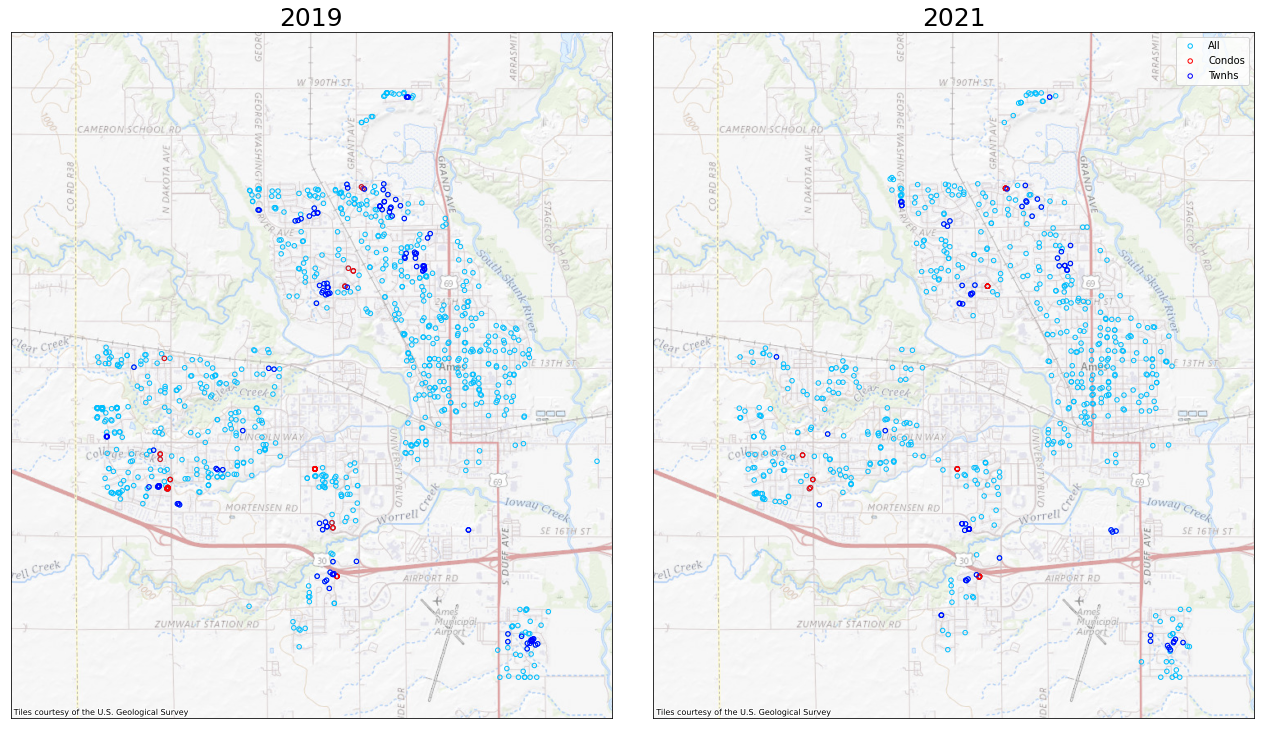

In [10]:
#Plotting locations of Condos and Townhouses sold in both 2019 and 2021 
plot_by_condition(["True", "BldgType == 'Condo'", "BldgType.str.contains('Twnhs')"], ["deepskyblue", "red", "blue"], 'o', ["All", "Condos", "Twnhs"])

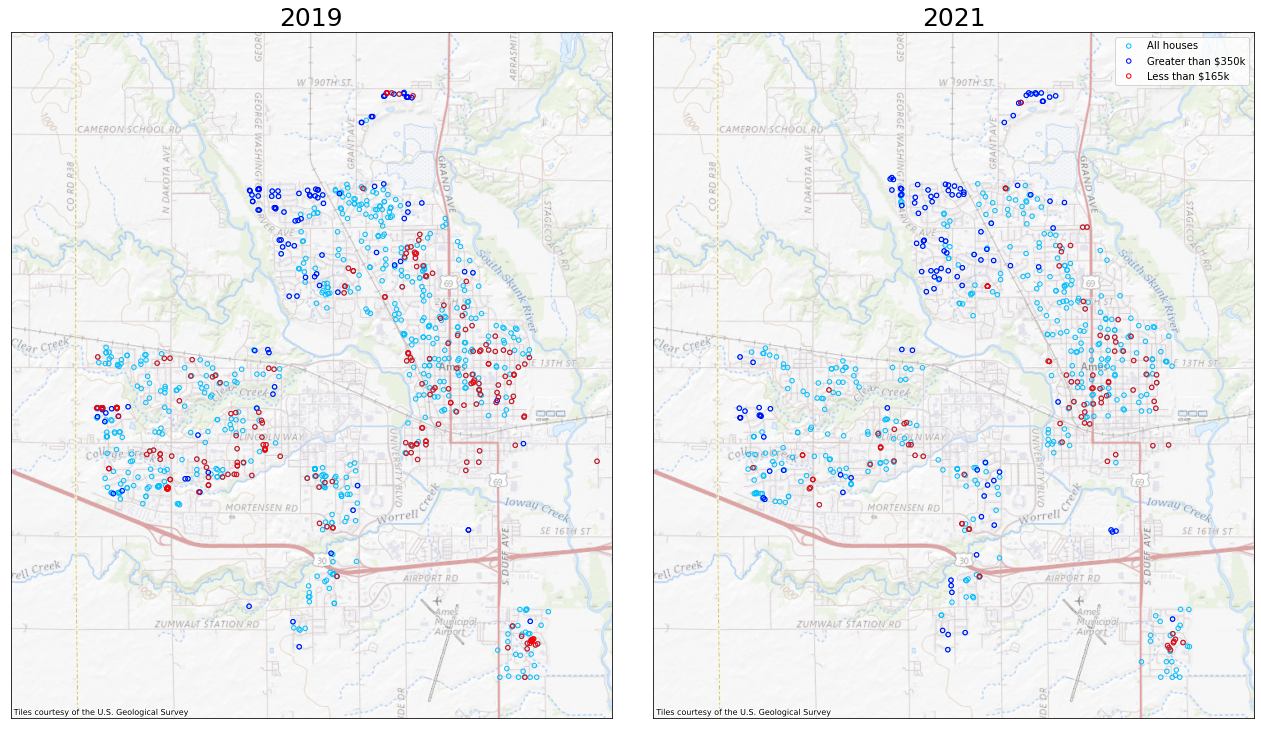

In [11]:
#Plotting SalePrice extremes and rest of the houses
plot_by_condition(["True", "SalePrice > 350000", "SalePrice < 165000"], ["deepskyblue", "blue", "red"], "o", ["All houses", "Greater than $350k", "Less than $165k"])

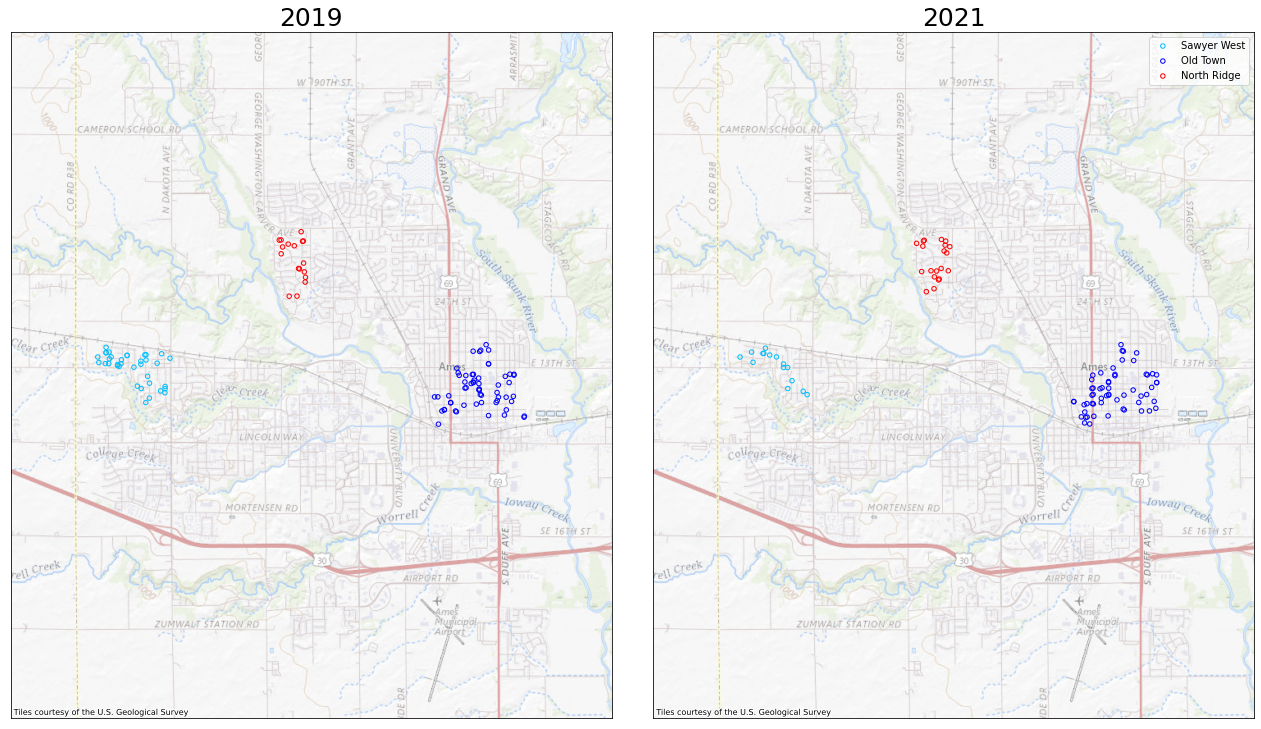

In [14]:
#Plotting sales in neighborhoods selected from AB testing (SawyerW, OldTown, NorthRidge) for both 2019 and 2021
plot_by_condition(["Neighborhood == 'SawyerW'", "Neighborhood == 'OldTown'", "Neighborhood == 'NoRidge'"], ["deepskyblue", "blue", "red"], "o", ["Sawyer West", "Old Town", "North Ridge"])

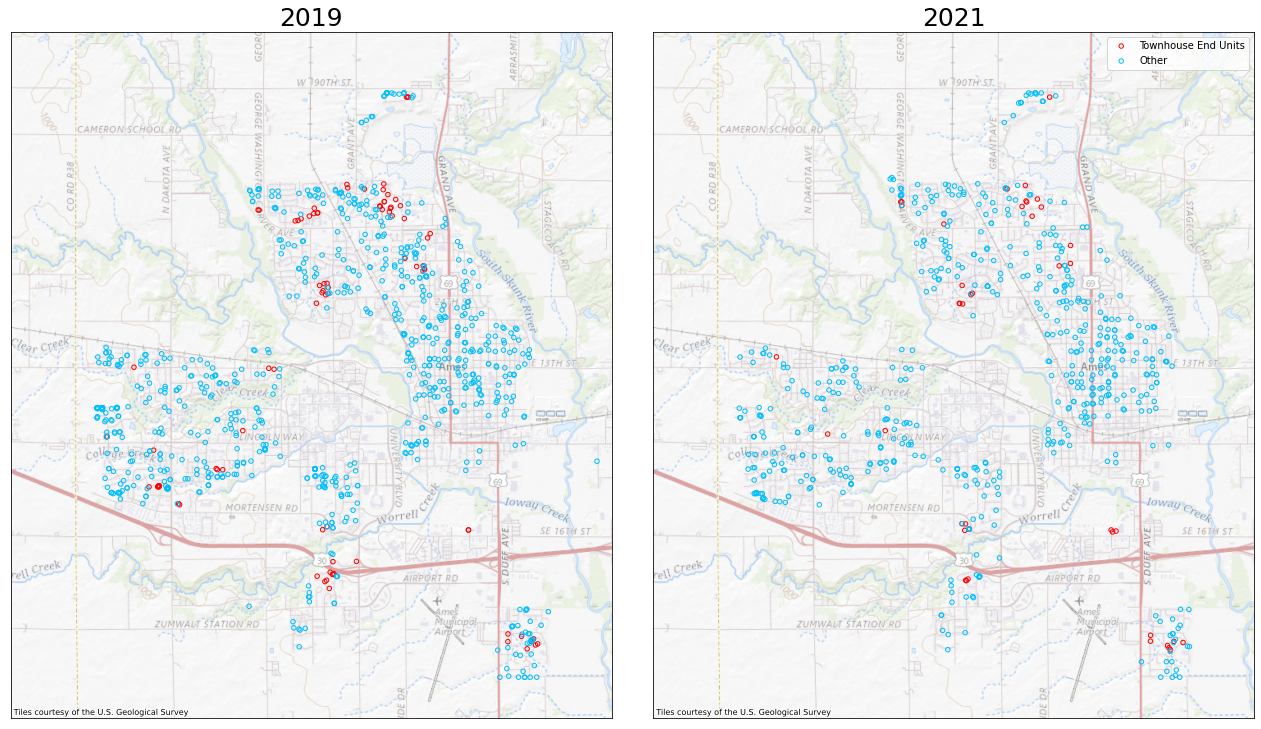

In [15]:
#Plotting townhouse end units sales for both 2019 and 2021
plot_by_condition(["BldgType == 'Twnhs-E'", "BldgType != 'Twnhs-E'"], ["red", "deepskyblue"], "o", ["Townhouse End Units", "Other"])

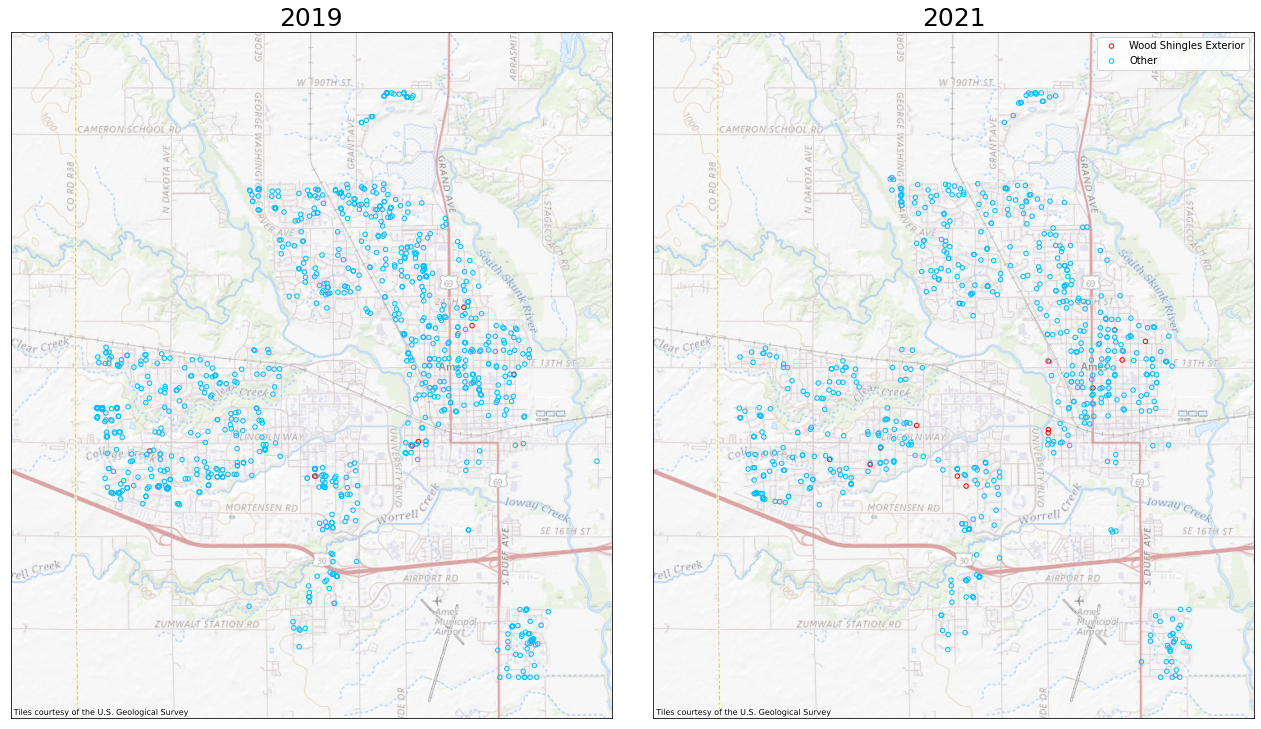

In [16]:
#Plotting sales of homes with wood singles exterior for both 2019 and 2021
plot_by_condition(["Ext1 == 'WdShing' or Ext2 == 'Wd Shing'", "Ext1 != 'WdShing' and Ext2 != 'Wd Shing'"], ["red", "deepskyblue"], "o", ["Wood Shingles Exterior", "Other"])

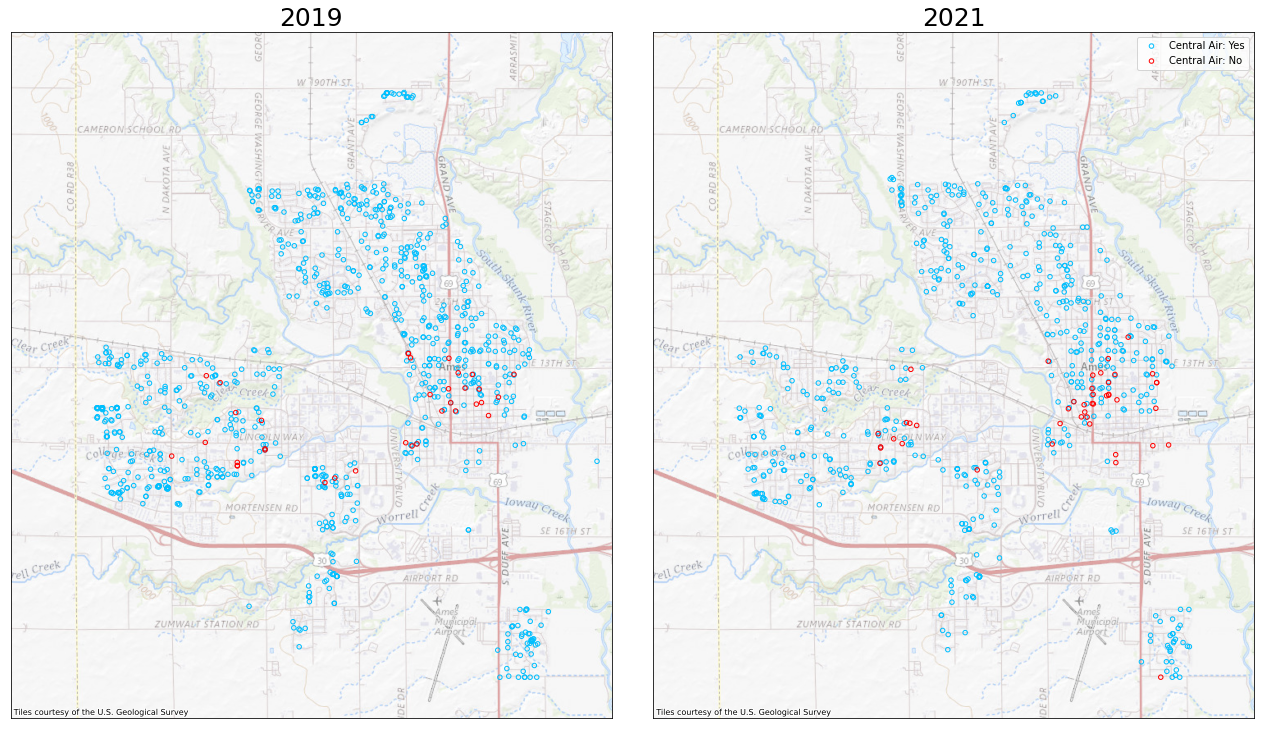

In [17]:
#plotting homes with no central air for both 2019 and 2021
plot_by_condition(["`Central Air` == 'Yes'", "`Central Air` != 'Yes'"], ["deepskyblue", "red"], "o", ["Central Air: Yes", "Central Air: No"])

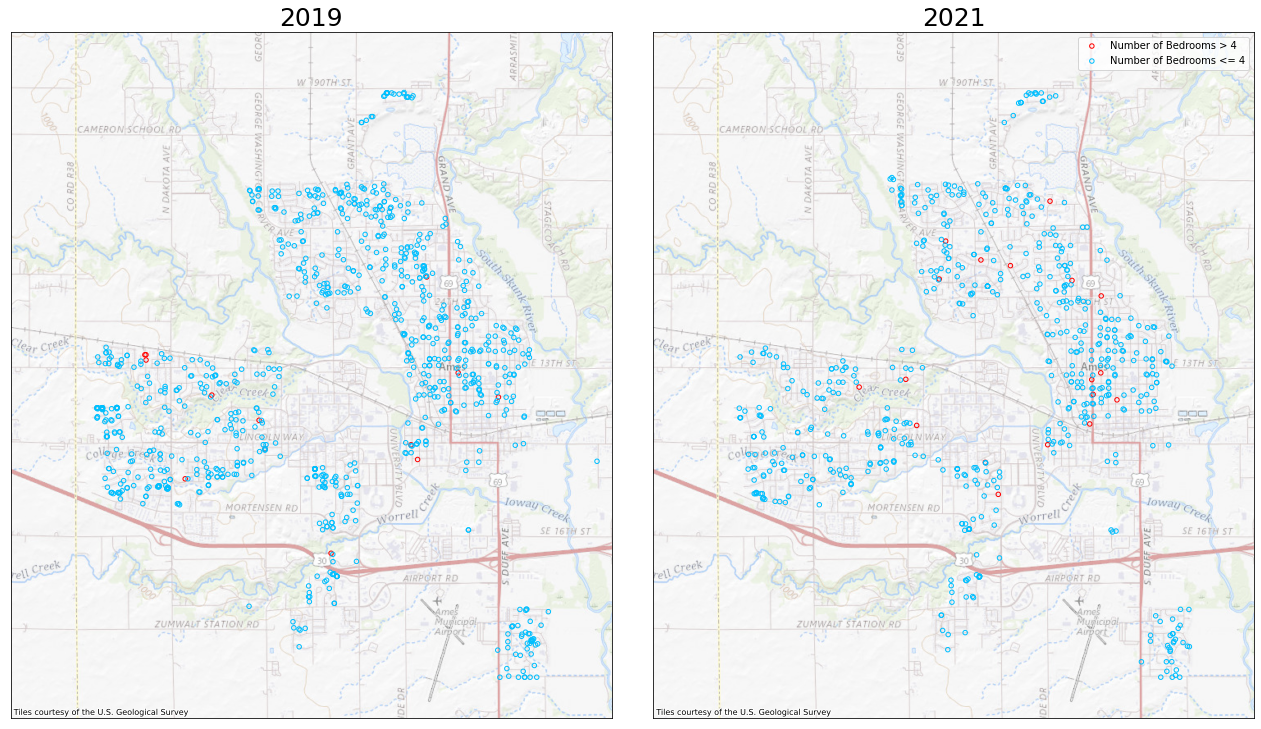

In [18]:
#plotting sales of homes with more than 4 bedrooms for both 2019 and 2021
plot_by_condition(["NmbrBRs >= 5", "NmbrBRs < 5"], ["red", "deepskyblue"], "o", ["Number of Bedrooms > 4", "Number of Bedrooms <= 4"])

### Number of Sales by Year and Month Bar Charts

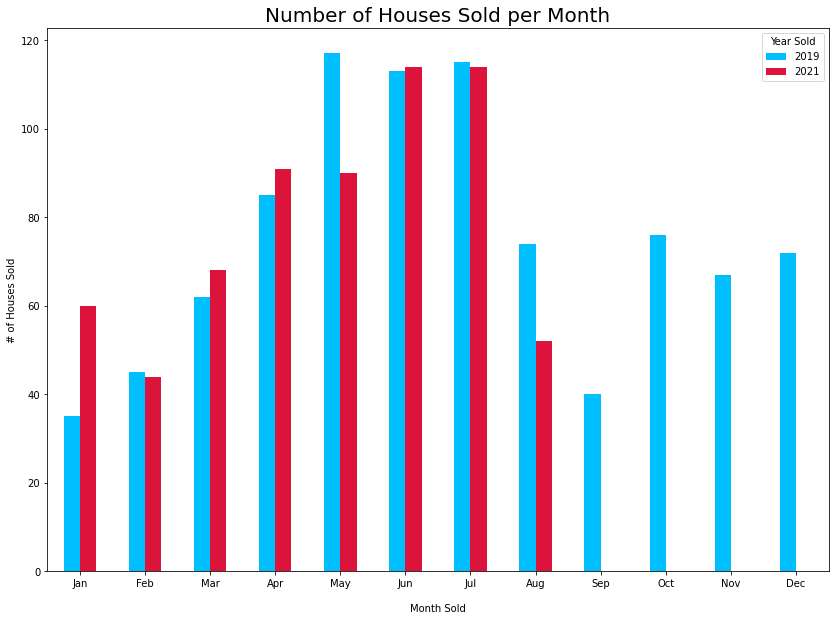

In [12]:
(df_wm_house
    .apply(lambda x: x if x.name != "YrSold_YYYY" else x.astype(int))
    .groupby(["YrSold_YYYY"]).MoSold_MM
    .value_counts()
    .unstack(level = 0)
    .fillna(0)
    .reset_index()
    .astype(int)
    .apply(lambda x: x if x.name != "MoSold_MM" else [calendar.month_abbr[i] for i in x])
    .set_index("MoSold_MM")
    .plot(kind = "bar", 
          figsize = (14,10),
          cmap = cmap
          )
)
plt.title("Number of Houses Sold per Month", fontsize = 20)
plt.xlabel("\nMonth Sold")
plt.ylabel("# of Houses Sold")
plt.xticks(rotation = 0)
plt.legend(title = "Year Sold");

### Show all Area/SF fields and engineered fields in one bar chart

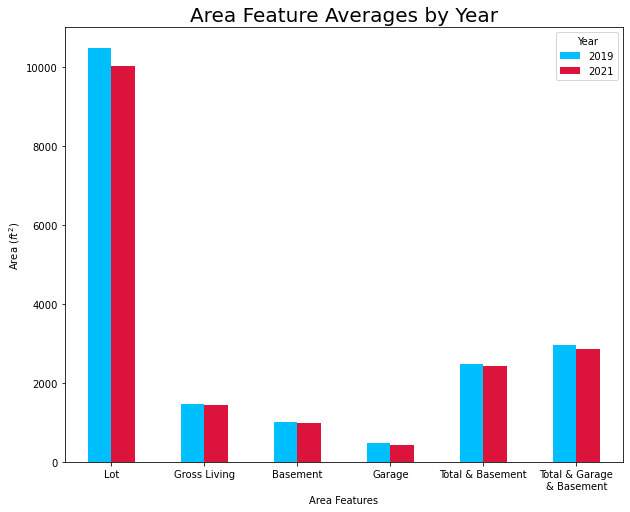

In [14]:
(df_feature_all_encoded
    .filter(regex = "Area|SF|GLA|Year")
    .drop("PoolArea", axis = 1)
    .groupby("Year")
    .mean()
    .T
    .reset_index()
    .rename(columns = {"index": "label"})
    .replace({"label":display_name_dict})
    .assign(label = lambda x: x.label.str.replace("Area:\n", ""))
    .set_index("label")
    .plot(kind = "bar", 
            figsize = (10,8),
            cmap = cmap
        )
)
plt.title("Area Feature Averages by Year", fontsize = 20)
plt.xticks(rotation = 0)
plt.xlabel("Area Features")
plt.ylabel("Area ($ft^2$)");

### Show frequency table of “Has_” boolean fields


/var/folders/2n/5k95xl754cb_szsgjkmj33k80000gn/T/ipykernel_95703/765974806.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


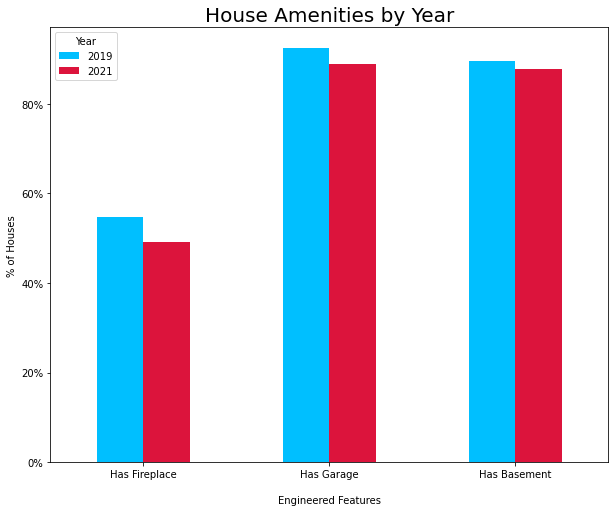

In [15]:
(df_feature_all_encoded
    .filter(regex = "Has_|Year")
    .groupby("Year")
    .mean()
    .T
    .reset_index()
    .replace({"index": display_name_dict})
    .set_index("index")
    .plot(kind = "bar",
            figsize = (10,8),
            cmap = cmap
        )
)
ax = plt.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.title("House Amenities by Year", fontsize = 20)
plt.xticks(rotation = 0)
plt.xlabel("\nEngineered Features")
plt.ylabel("% of Houses");

### Percentage of Houses Sold by Building Type for 2019 vs. 2021

/var/folders/2n/5k95xl754cb_szsgjkmj33k80000gn/T/ipykernel_95703/1085873113.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


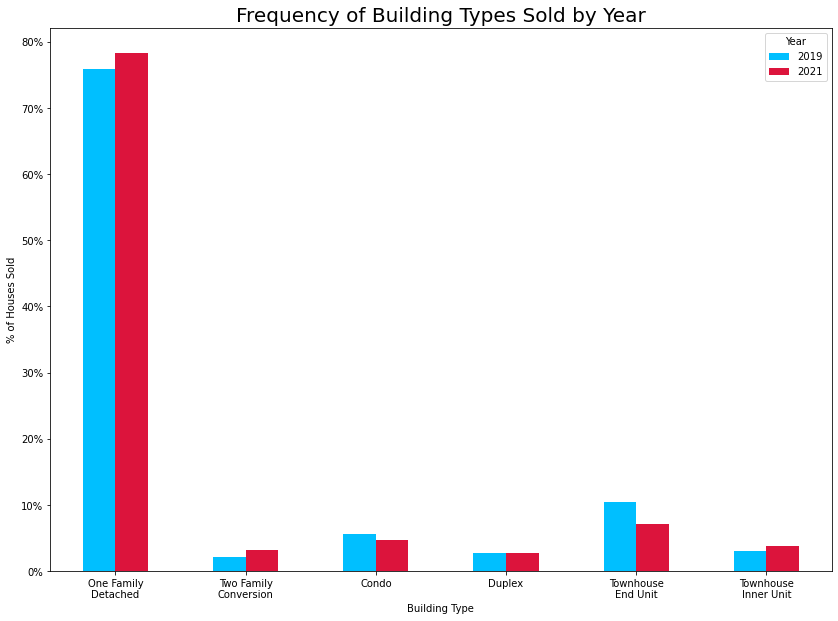

In [16]:
(df_house_both
    .pipe(remove_undeveloped_lots)
    .groupby("Year").BldgType
    .value_counts(normalize = True)
    .unstack(level = 0)
    .reset_index()
    .replace({"BldgType":display_bldgtype_dict})
    .set_index("BldgType")
    .plot(kind = "bar", 
          figsize = (14,10),
          cmap = cmap
          )
)
ax = plt.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.title("Frequency of Building Types Sold by Year", fontsize = 20)
plt.ylabel("% of Houses Sold")
plt.xlabel("Building Type")
plt.xticks(rotation = 0);

### Show Correlations using heatmap to show which fields are more correlated to SalePrice


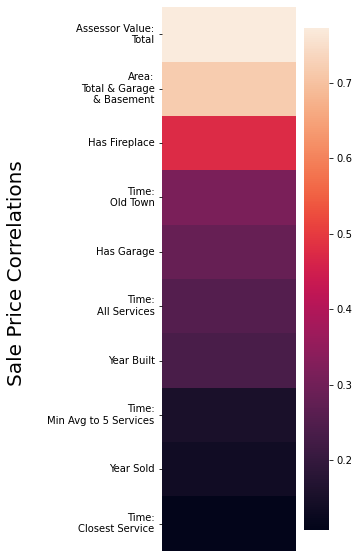

In [17]:
plt.figure(figsize = (3,10))
sns.heatmap(df_feature_all_encoded
    .filter(regex = "Has_|Area|GLA|SF|Yr|Closest_Time|Closest_5|Convenience|Central_historic")
    .drop("PoolArea", axis = 1)
    .join(df_wm_house.SalePrice)
    .corr()
    .SalePrice
    .sort_values(ascending = False)
    .to_frame()
    .query("index not in ['SalePrice', 'GLA', 'TotalArea', 'TtlBsmtSF', 'GarageArea', 'LotArea', 'GarYrBlt', 'Has_Bsmt']")
    .head(10)
    .rename(index = display_name_dict)
)
plt.xticks([])
plt.title("Sale Price Correlations\n", fontsize = 20, rotation = 'vertical', x = -1, y = 0.3);

### Data Visualization of the Important Fields for Descriptive and Predictive Models


<Figure size 1008x1008 with 0 Axes>

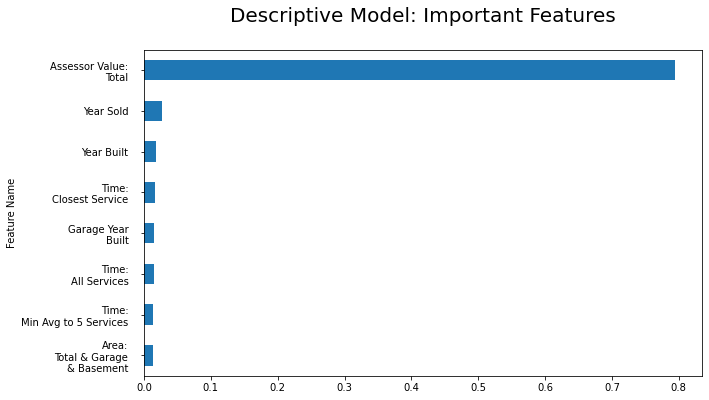

In [18]:
(EDA_report(df_feature_all_both
                .drop("Year", axis = 1)
                .pipe(remove_undeveloped_lots, df_wm_house)
                .join(df_house_both[["SalePrice"]])
)["important_features"]
            .sort_values("Importance", ascending = True)
            .tail(8)
            .set_index("Name")
            .rename(index = display_name_dict)
            .reset_index()
            ).plot(kind = 'barh', x = "Name", y = "Importance", figsize = (10,6))
plt.ylabel("Feature Name")
plt.gca().tick_params(axis = "y", which = "major", pad = 12)
plt.gca().get_legend().remove()
plt.title("Descriptive Model: Important Features\n", fontsize = 20);

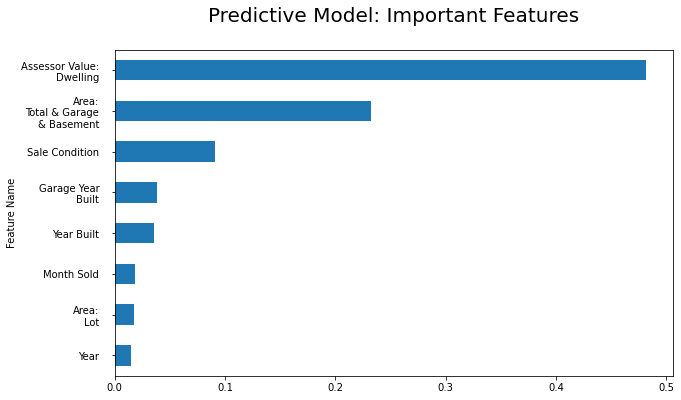

In [19]:
(find_important_features(load_state_pkl()["Final_Model"][0]["GBR"]["Model"])
    .sort_values("Importance", ascending = True)
    .tail(8)
    .set_index("Name")
    .rename(index = display_name_dict)
    .reset_index()
    .plot(kind = "barh", x = "Name", y = "Importance", figsize = (10,6))
)
plt.ylabel("Feature Name")
plt.gca().tick_params(axis = "y", which = "major", pad = 12)
plt.gca().get_legend().remove()
plt.title("Predictive Model: Important Features\n", fontsize = 20);

### Graphviz decision tree for one estimator of the Final Model

In [803]:
# #load_state_pkl()["Final_Model"][0]["GBR"]["Model"].estimators_[0, 0]

# tree.export_graphviz(load_state_pkl()["Final_Model"][0]["GBR"]["Model"].estimators_[1, 0], 
#                         out_file = 'Visualizations/graphviz_tree_1.dot', 
#                         feature_names = load_state_pkl()["Final_Model"][0]["GBR"]["Model"].feature_names_in_, 
#                         label = "root", 
#                         impurity = False,
#                         max_depth = 2
#                     )

In [ ]:
#dot -Tpng graphviz_tree.dot -o graphviz_tree.png

In [ ]:
# from IPython.display import Image
# Image(filename='Visualizations/graphviz_tree.png')

### Sale Price vs. Other (Dwelling) House Assessor Value Plot

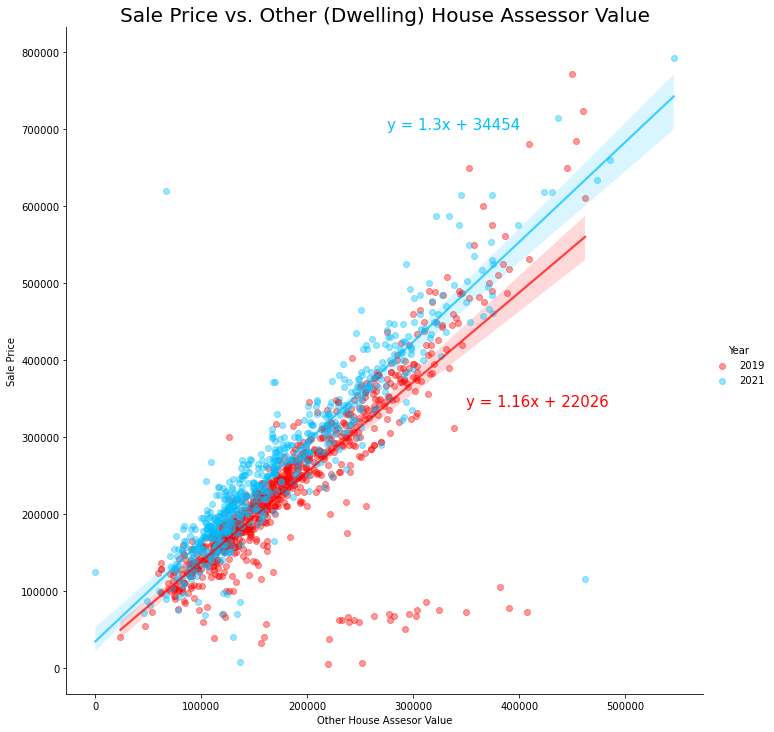

In [47]:
#calculating regression line equations for 2019 and 2021
def get_reg_equation (x, y):
    slope, intercept, _, _, _ = linregress(x, y)
    return f"y = {round(slope, 2)}x + {round(intercept)}"

x_2021 = df_feature_all_encoded.join(df_house_both.SalePrice).pipe(remove_undeveloped_lots).query("YrSold_YYYY == 2021").OthAc_S
y_2021 = df_feature_all_encoded.join(df_house_both.SalePrice).pipe(remove_undeveloped_lots).query("YrSold_YYYY == 2021").SalePrice
equation_2021 = get_reg_equation(x_2021, y_2021)

x_2019 = df_feature_all_encoded.join(df_house_both.SalePrice).pipe(remove_undeveloped_lots).query("YrSold_YYYY == 2019").OthAc_S
y_2019 = df_feature_all_encoded.join(df_house_both.SalePrice).pipe(remove_undeveloped_lots).query("YrSold_YYYY == 2019").SalePrice
equation_2019 = get_reg_equation(x_2019, y_2019)

#Plotting regression lines with respective equations
sns_cmap = sns.color_palette(["red", "deepskyblue"])
(sns.lmplot(x = 'OthAc_S', 
            y = 'SalePrice', 
            data = df_feature_all_encoded.join(df_house_both.SalePrice).pipe(remove_undeveloped_lots), 
            hue = 'Year',
            height = 10,
            palette = sns_cmap,
            scatter_kws = {"alpha": 0.4},
            line_kws = {"alpha": 0.7}
            )
)
plt.text(275000, 700000, equation_2021, fontdict = {"fontsize": 15, "color": "deepskyblue"})
plt.text(350000, 340000, equation_2019, fontdict = {"fontsize": 15, "color": "red"})
plt.title("Sale Price vs. Other (Dwelling) House Assessor Value", fontsize = 20)
plt.xlabel("Other House Assesor Value")
plt.ylabel("Sale Price");

### Number of Businesses within 180 Seconds vs. 480 Seconds from Each House Plot

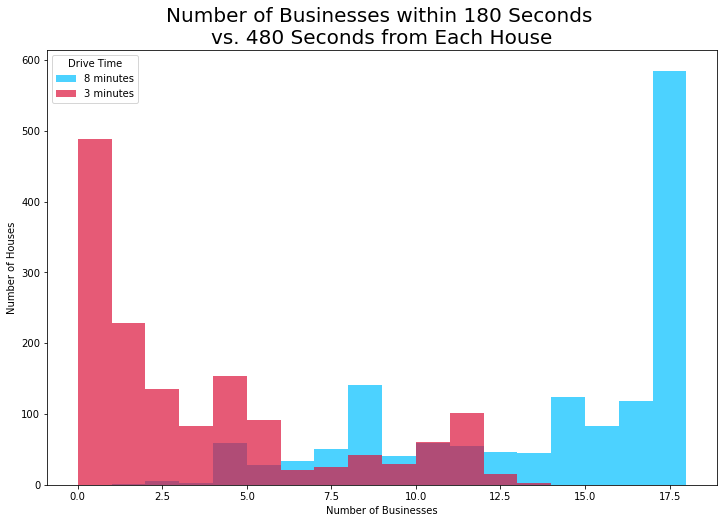

In [20]:
(df_feature_all_encoded.pipe(remove_undeveloped_lots, df_wm_house)
    [["biz_480_secs", "biz_180_secs"]]
    .set_axis(["8 minutes", "3 minutes"], axis = 1)
    .plot
    .hist(alpha = 0.7, 
            cmap = cmap,
            bins = 18,
            figsize = (12,8)
        )
)

plt.legend(title = "Drive Time")
plt.xlabel("Number of Businesses")
plt.ylabel("Number of Houses")
plt.title("Number of Businesses within 180 Seconds \nvs. 480 Seconds from Each House", fontsize = 20);

### Closest Service by Year Plot

/var/folders/2n/5k95xl754cb_szsgjkmj33k80000gn/T/ipykernel_95703/2486130720.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


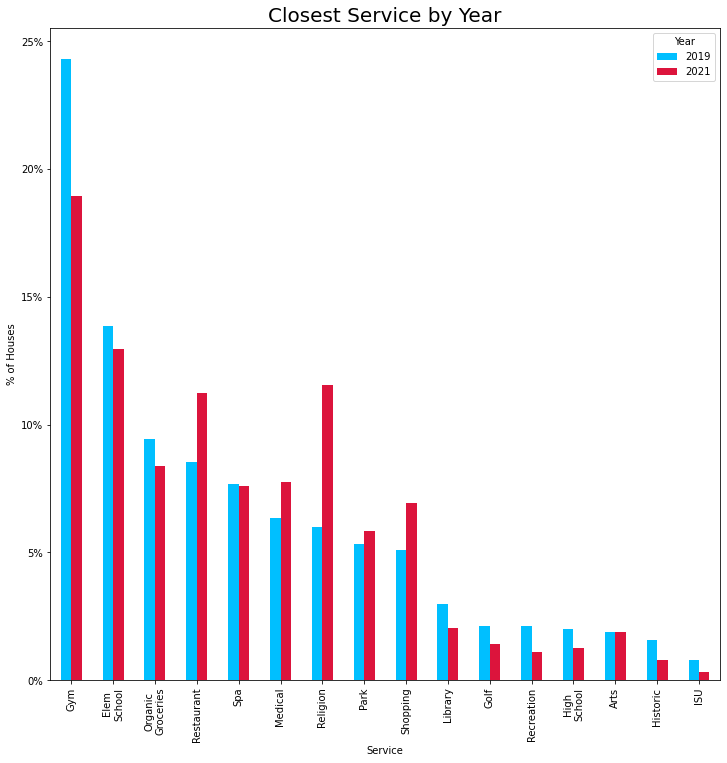

In [21]:
(df_feature_all_encoded
    .filter(regex = "_closest|Year")
    .groupby("Year")
    .mean()
    .T
    .reset_index()
    .set_index([2019, 2021])
    ["index"]
    .str.replace("_closest", "")
    .str.replace("Service_", "")
    .str.replace("_", "\n")
    .sort_index(ascending = False)
    .reset_index()
    .plot.bar(x = 'index', 
                figsize = (12,12), 
                xlabel = "Service", 
                ylabel = "% of Houses",
                cmap = cmap
            )
)
ax = plt.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.title("Closest Service by Year", fontsize = 20)
plt.legend(title = "Year");

## Business/Service Locations Map

In [22]:
rand_color_list = ['black', 'blue', 'brown', 'purple', 'red', 'orange',
                    'gray', 'gold', 'deepskyblue', 'salmon', 'chocolate', 'deeppink', 
                    'green', 'limegreen', 'darkkhaki', 'teal', 'fuchsia', 'rosybrown'
                    ]

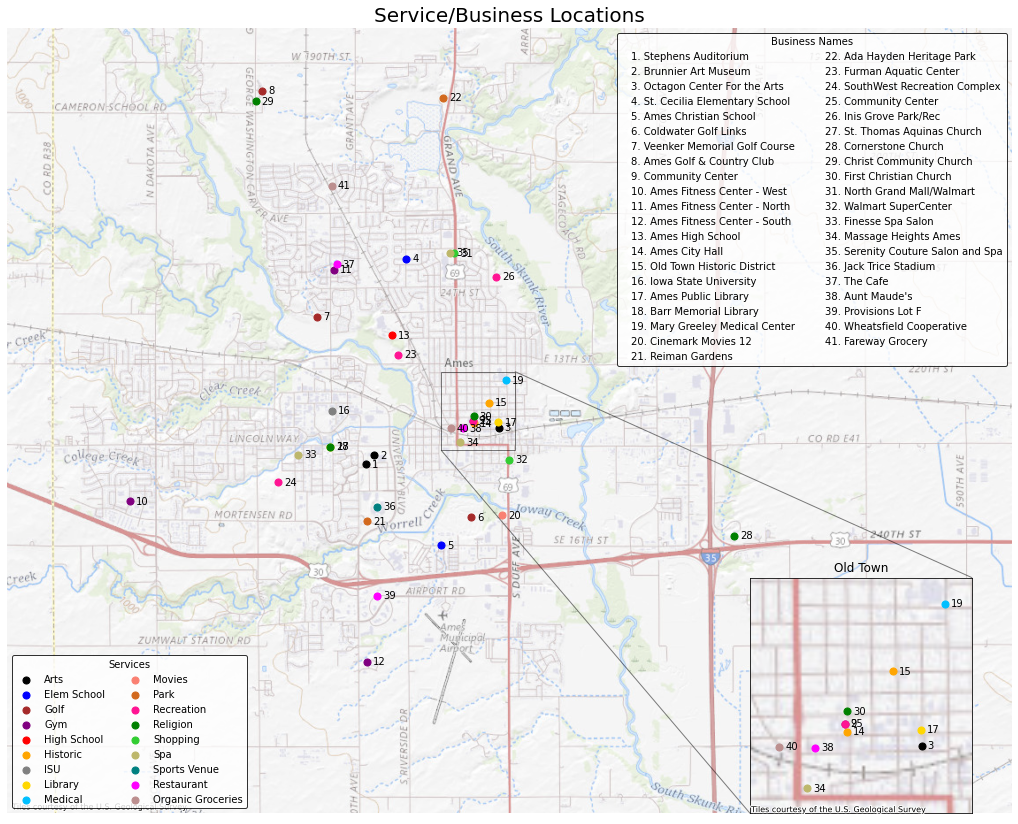

In [23]:
#function that maps services within the axis
def map_services(ax):
    for service, colo in [(s,c) for c,s in zip(rand_color_list, df_wm_biz.Service.unique())]:
        df_wm_biz.query(f"Service == '{service}'").plot(ax = ax, markersize = 50, marker = "o", label = service.replace("_", " "), c = colo)

    for row in df_wm_biz.iterrows():
        ax.annotate(row[1].biz_num, xy = (row[1].geometry.x, row[1].geometry.y), xytext = (6,-3), textcoords = "offset points")
    cx.add_basemap(ax = ax, source = cx.providers.USGS.USTopo, alpha = 0.7)


ax = df_wm.query("index > 0").plot(figsize = (18,18), alpha = 0)

#mapping parent map
map_services(ax)


plt.title("Service/Business Locations", fontdict = {"fontsize":"20"})

#legend for services
legend1 = plt.legend(loc = "lower left", ncol = 2, title = "Services", edgecolor = "black")
plt.gca().add_artist(legend1)

#Legend for businesses
legend2_elements = []
for text, biz_num in zip(df_wm_biz.Name, df_wm_biz.biz_num):
    legend2_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="white", markersize=8, label=str(biz_num) + ". " + text))
plt.legend(handles=legend2_elements, ncol = 2, title='Business Names', loc='upper right', handletextpad = -1, edgecolor = "black")

#mapping inset to get a zoom in of OldTown 
axins = ax.inset_axes([0.7, 0, 0.3, 0.3])
map_services(axins)


axins.set_xlim(-1.04221e7, -1.04205e7)
axins.set_ylim(5.1643e6, 5.166e6)
axins.set_title("Old Town")
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xticks([])
axins.set_yticks([])


ax.indicate_inset_zoom(axins, edgecolor = "black")


plt.axis("off")

plt.show()

## Neighborhood Map Ames Iowa

In [ ]:
#This cell takes a little wile to run (~6mins)

#Creates topographical map divided by neighborhoods
N = 300
x = np.linspace(-1.0432e7, -1.0418e7, N)
y = np.linspace(5.158e6, 5.174e6, N)
coords = np.array(np.meshgrid(x, y)).T.reshape(N**2, 2)

homes = np.array([[point.x, point.y] for point in df_wm_house.geometry])


get_dist = lambda a,b: np.sqrt(sum((a-b)**2))
get_dist(homes[0], coords[0])

closest_neighborhood = []
min_dists = []
i = 0
for c in coords:
    dists = [get_dist(h, c) for h in homes]
    closest_home_index = np.argmin(dists)
    min_dists.append(dists[closest_home_index])
    closest_neighborhood.append(df_wm_house.Neighborhood.values[closest_home_index])
    print(i)
    i+=1

In [31]:
#defining offset list for neighborhood map feat. saleprice annotations
offset_list = [(-130, -30), (-125, 0), (70, -10), (-25, 50), (-30, -45)]

neighborhood_annot = (df_wm_house
    .eval("x = geometry.x")
    .eval("y = geometry.y")
    .groupby("Neighborhood")
    .mean()
    [["x", "y", "SalePrice"]]
    .join(df_wm_house
                .Neighborhood
                .value_counts()
                .rename("N")
        )
    .T
    [["NoRidge", "SawyerW", "OldTown", "Sawyer", "DakotaR"]]
    .T
    .set_axis(["North Ridge (Max)", "Sawyer West", "Old Town", "Sawyer (Median)", "Dakota Ridge Condos (Min)"])
    .assign(offset = offset_list)
    .assign(N = lambda x: x.N.astype(int))
)


In [28]:
#Function that standardizes the gridlines and axes of neighborhood plots
def finalize_plot(ax):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    plt.xlabel("\n \n")
    fig = plt.gcf()
    fig.set_dpi(300)

#Function that plots neighborhood maps featuring a specific field condition
def plot_neighborhood_map (mapper = None, main_field = "SalePrice", legend_title = "Neighborhoods"):

    df = pd.DataFrame([closest_neighborhood, [Point(c[0], c[1]) for c in coords]], index = ['Neighborhood', 'geometry']).T
    neighborhood_map = gpd.GeoDataFrame(df, crs = "epsg:3857").eval("dist = @min_dists")
    ax = df_wm.query("index > 0").plot(figsize = (19.7, 19.7), alpha = 0)

    if mapper is None:
        for nh, c in zip(df_wm_house.Neighborhood.unique(), color_list[np.random.choice(len(color_list) - 1, 33, replace = False)]):
            neighborhood_map.query("Neighborhood == @nh").plot(ax = ax, markersize = 25, marker = "o", color = c, alpha = 0.025)
            df_wm_house.query("Neighborhood == @nh").plot(ax = ax, markersize = 25, marker = "o", color = c, label = nh)


        bbox = dict(boxstyle = "round, pad = 0.5", facecolor = "white")

        for row in neighborhood_annot.iterrows():
            annotation = f"{row[0]}: \n${row[1].SalePrice:,.2f}"
            ax.annotate(annotation, xy = (row[1].x, row[1].y), xytext = row[1].offset, textcoords = "offset points", bbox = bbox)

        ax.legend(loc = "upper left", ncol = 2, title = legend_title)

    else:
        df_plot_nh = (gpd.GeoDataFrame(mapper
                        .merge(neighborhood_map, on = "Neighborhood"), crs = "epsg:3857")
                        .eval("x = geometry.x")
                        .eval("y = geometry.y")
                        )
        df_plot_house = (df_wm_house
                            .drop(main_field, axis = 1, errors = "ignore")
                            .merge(mapper, on = "Neighborhood")
                            .eval("x = geometry.x")
                            .eval("y = geometry.y") 
                        )
        plt.scatter(df_plot_nh.x, df_plot_nh.y, c = df_plot_nh[main_field], cmap = cmap, alpha = 0.025)
        scatter_plot = plt.scatter(df_plot_house.x, df_plot_house.y, cmap = cmap, marker = "o", facecolors = 'none', c = df_plot_house[main_field])
        cb = plt.colorbar(scatter_plot, shrink = 0.45, location = "bottom", pad = -0.075)
        cb.set_label(label = legend_title, weight = "bold", size = 15)


    ax.set_xlim((-1.0432e7, -1.0418e7))
    ax.set_ylim((5.158e6, 5.174e6))

    finalize_plot(ax)

    plt.title(f"\nAmes Neighborhood Map (feat. {display_name_dict[main_field].replace(os.linesep, ' ')})", fontsize = 20)
    cx.add_basemap(ax = ax, source = cx.providers.USGS.USTopo, alpha = 0.7)

### feat. Fireplaces

In [25]:
df_fireplaces = df_feature_all_both.join(df_wm_house.Neighborhood).groupby("Neighborhood").Fireplaces.mean().reset_index()

In [ ]:
plot_neighborhood_map(df_fireplaces, main_field = "Fireplaces", legend_title = "Average # of Fireplaces")

### feat. TotalArea_Gar

In [ ]:
df_TotalArea_Gar = df_feature_all_both.join(df_wm_house.Neighborhood).groupby("Neighborhood").TotalArea_Gar.mean().reset_index()
df_TotalArea_Gar

In [ ]:
plot_neighborhood_map(df_TotalArea_Gar, main_field = "TotalArea_Gar", legend_title = "Average Total Area with Garage and Basement " + r"$\bf{(ft^2)}$")

### feat. Closest_Time

In [1644]:
df_Closest_Time = df_feature_all_both.join(df_wm_house.Neighborhood).groupby("Neighborhood").Closest_Time.mean().reset_index()

In [ ]:
plot_neighborhood_map(df_Closest_Time, "Closest_Time", "Average Drive Time to Closest Service")

### feat. Closest_5

In [209]:
df_Closest_5 = df_feature_all_both.join(df_wm_house.Neighborhood).groupby("Neighborhood").Closest_5.mean().reset_index()

In [ ]:
plot_neighborhood_map(df_Closest_5, "Closest_5", "Average Drive Time to Closest 5 Services (s)")

### feat. YrBuilt

In [1656]:
df_YrBuilt = df_feature_all_both.pipe(remove_undeveloped_lots, df_wm_house).join(df_wm_house.Neighborhood).groupby("Neighborhood").YrBuilt.mean().reset_index()

In [ ]:
plot_neighborhood_map(df_YrBuilt, "YrBuilt", "Average House Year Built")

### feat. Cars

In [1665]:
df_Cars = df_feature_all_both.pipe(remove_undeveloped_lots, df_wm_house).join(df_wm_house.Neighborhood).groupby("Neighborhood").Cars.mean().reset_index()

In [ ]:
plot_neighborhood_map(df_Cars, "Cars", "Average # of Cars per Garage")

### feat. Sale Price

In [ ]:
df = pd.DataFrame([closest_neighborhood, [Point(c[0], c[1]) for c in coords]], index = ['Neighborhood', 'geometry']).T
neighborhood_map = gpd.GeoDataFrame(df, crs = "epsg:3857").eval("dist = @min_dists")
ax = df_wm.query("index > 0").plot(figsize = (16,16), alpha = 0)

np.random.seed(5)
for nh, c in zip(df_wm_house.Neighborhood.unique(), color_list[np.random.choice(len(color_list) - 1, 33, replace = False)]):
    neighborhood_map.query("Neighborhood == @nh").plot(ax = ax, markersize = 25, marker = "o", color = c, alpha = 0.025)
    df_wm_house.query("Neighborhood == @nh").plot(ax = ax, markersize = 25, marker = "o", color = c, label = Neighborhood_name_dict[nh])

bbox = dict(boxstyle = "round, pad = 0.5", facecolor = "white")

for row in neighborhood_annot.iterrows():
    annotation = f"{row[0]}: \n${row[1].SalePrice:,.2f}\n{row[1].N} residences"
    ax.annotate(annotation, xy = (row[1].x, row[1].y), xytext = row[1].offset, textcoords = "offset points", bbox = bbox)

ax.set_xlim((-1.0432e7, -1.0418e7))
ax.set_ylim((5.158e6, 5.174e6))
ax.legend(loc = "upper left", ncol = 2, title = "Neighborhoods", edgecolor = 'black')
finalize_plot(ax)
plt.title("\nAmes Neighborhood Map (feat. Sale Price)", fontsize = 20)
cx.add_basemap(ax = ax, source = cx.providers.USGS.USTopo, alpha = 0.7)

## Title Page Slide Background

In [ ]:
ax = df_wm.query("index > 0").plot(figsize = (18,18), alpha = 0)
cx.add_basemap(ax = ax, source = cx.providers.USGS.USTopo, alpha = 0.5)
ax.set_xlim((-1.0428e7, -1.0416e7))
ax.set_ylim((5.161e6, 5.172e6))
fig = plt.gcf()
fig.set_dpi(300)
ax.axis("off");